In [1]:
library(parallel)
# 查看可用的CPU核心数
detectCores(logical = FALSE)


[1] 32

In [2]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(scMEGA))
suppressMessages(library(Nebulosa))
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))
suppressMessages(library(GenomeInfoDb))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(JASPAR2020))
suppressMessages(library(TFBSTools))
suppressMessages(library(igraph))
suppressMessages(library(ggraph))
suppressMessages(library(MOJITOO))

Warning message:
“package ‘ArchR’ was built under R version 4.3.3”
Warning message:
“package ‘gtools’ was built under R version 4.3.3”
Warning message:
“package ‘gtable’ was built under R version 4.3.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘magrittr’ was built under R version 4.3.3”
Warning message:
“package ‘plyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.3.3”
Warning message:
“package ‘rhdf5’ was built under R version 4.3.3”
Warning message:
“package ‘scMEGA’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.2”
Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg38’ was built under R version 4.3.3”
Warning message:
“package ‘EnsDb.Hsapiens.v86’ was built under R version 4.3.3”
Warning m

In [3]:
# 加载pryr包
library(pryr)

# 查看R进程当前内存使用
mem_used()

# 使用system2命令获取内存信息
system2("grep", "MemTotal /proc/meminfo", stdout = TRUE)



Warning message:
"package 'pryr' was built under R version 4.3.3"

Attaching package: 'pryr'


The following object is masked from 'package:igraph':

    compose


The following object is masked from 'package:dplyr':

    where


The following object is masked from 'package:data.table':

    address




1.37 GB

[1] "MemTotal:       2112594368 kB"

In [4]:

library(bench)


inputdata.10x <- Read10X_h5("/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/3KPBMC/filtered_feature_bc_matrix.h5")




Warning message:
"package 'bench' was built under R version 4.3.3"
Genome matrix has multiple modalities, returning a list of matrices for this genome



In [5]:
mem_used()

1.69 GB

In [6]:
library(hdf5r)


Attaching package: 'hdf5r'


The following object is masked from 'package:rtracklayer':

    values


The following object is masked from 'package:rhdf5':

    h5version


The following object is masked from 'package:SummarizedExperiment':

    values


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




In [7]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/models/R-scMEGA"

In [8]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [9]:
## Genome matrix has multiple modalities, returning a list of matrices for this genome
# extract RNA and ATAC data
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [10]:
# filter peaks by chromosome
atac_counts <- atac_counts[grep("chr", rownames(atac_counts)), ]

An object of class Seurat 
36601 features across 2622 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data

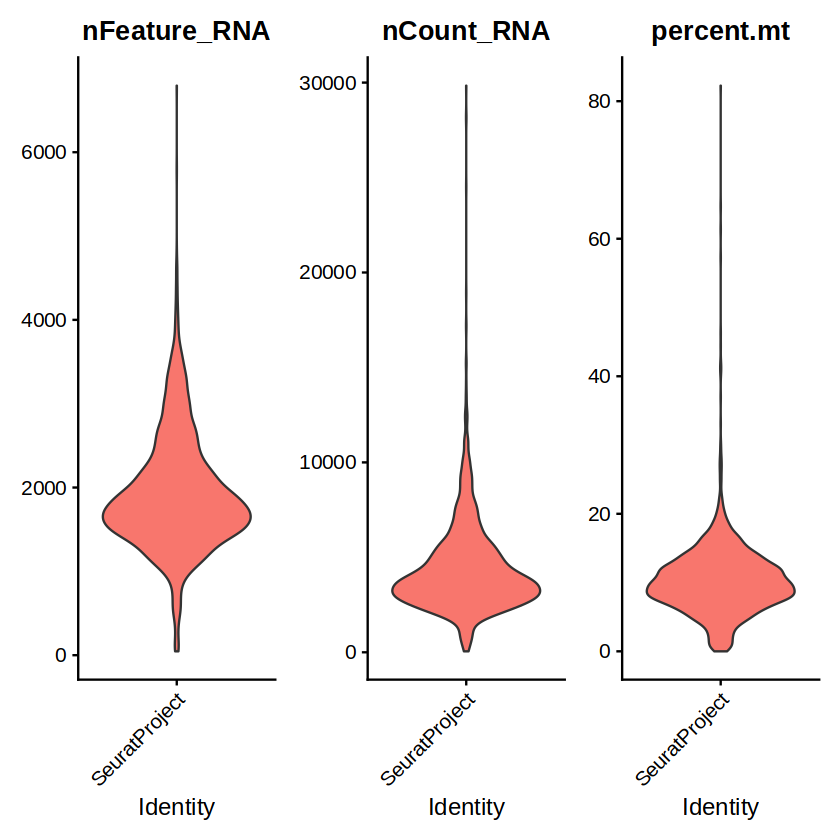

In [11]:
#接下来创建一个 Seurat 对象并过滤 scRNA-seq 数据中的低质量细胞
obj.rna <- CreateSeuratObject(counts = rna_counts)
obj.rna <- NormalizeData(obj.rna, verbose = FALSE)
obj.rna[["percent.mt"]] <- PercentageFeatureSet(obj.rna, pattern = "^MT-")
# Visualize QC metrics as a violin plot
vln1<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln1
#ggsave(filename='plot1.png',plot=vln1,width=16,height=12,dpi=600)
obj.rna <- subset(obj.rna, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20 & nCount_RNA < 13000)

obj.rna

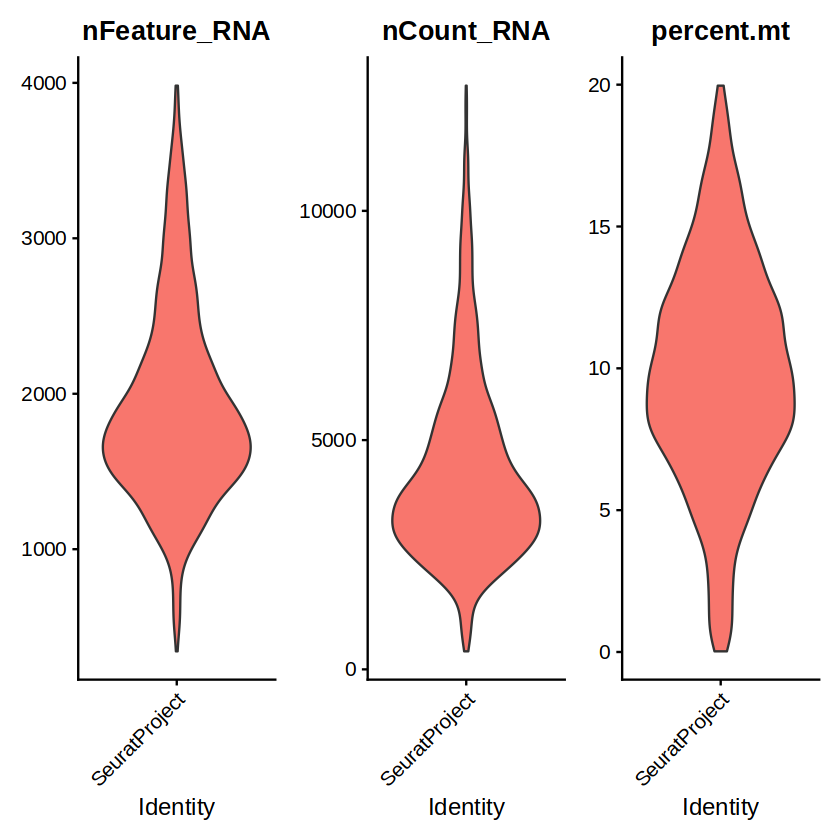

In [12]:
vln2<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln2
#ggsave(filename='plot2.png',plot=vln2,width=16,height=12,dpi=600)

In [13]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj"

In [14]:
# create seurat object
chrom_assay <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  min.cells = 1,
  genome = 'hg38',
  fragments = './3KPBMC/atac_fragments.tsv.gz'
)

Computing hash



In [15]:
obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC")

In [16]:
# extract gene annotations from EnsDb
#annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86, 
  #                                 verbose = FALSE)

In [17]:
# change to UCSC style since the data was mapped to hg38

#seqlevelsStyle(annotations) <- 'UCSC'


In [18]:
annotations<-readRDS("./models/R-scMEGA/annotations.rds")
mem_used()

2.54 GB

In [19]:
# add the gene information to the object
Annotation(obj.atac) <- annotations

In [20]:
annotations

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739     chrM     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789     chrM   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851     chrM     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899     chrM     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



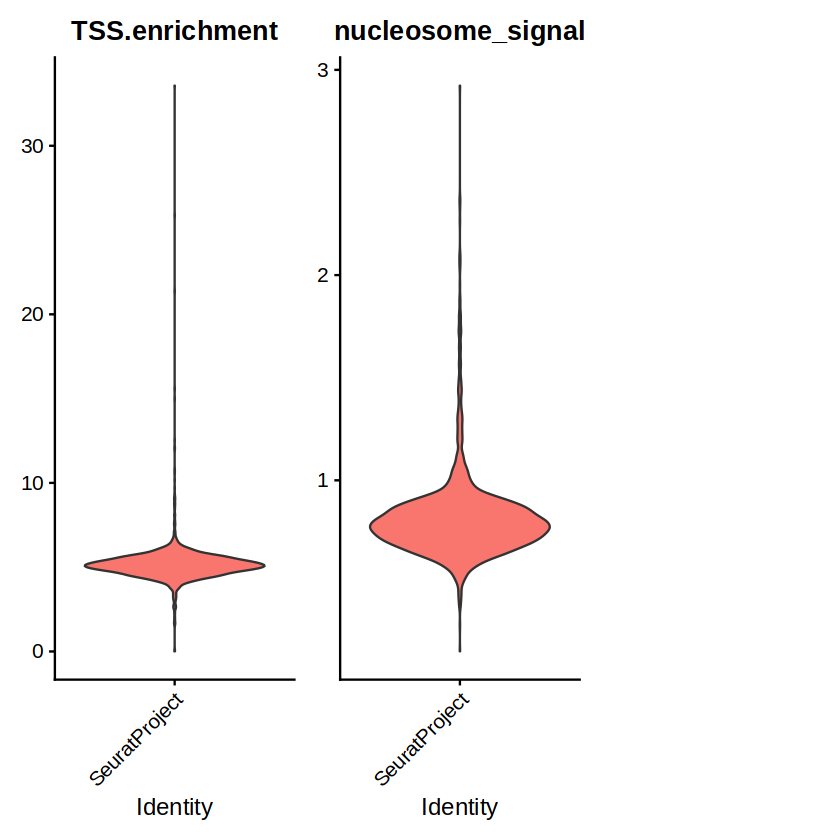

In [21]:
# 计算 TSS 富集分数
obj.atac <- TSSEnrichment(obj.atac, fast = FALSE)

# 计算核小体信号
obj.atac <- NucleosomeSignal(obj.atac)



VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)



In [22]:
obj.atac

An object of class Seurat 
151450 features across 2714 samples within 1 assay 
Active assay: ATAC (151450 features, 0 variable features)
 2 layers present: counts, data

In [23]:
# 过滤低质量细胞
obj.atac <- subset(
  x = obj.atac,
  subset =
           nucleosome_signal < 4 & 
           TSS.enrichment > 2
)

In [24]:
obj.atac

An object of class Seurat 
151450 features across 2706 samples within 1 assay 
Active assay: ATAC (151450 features, 0 variable features)
 2 layers present: counts, data

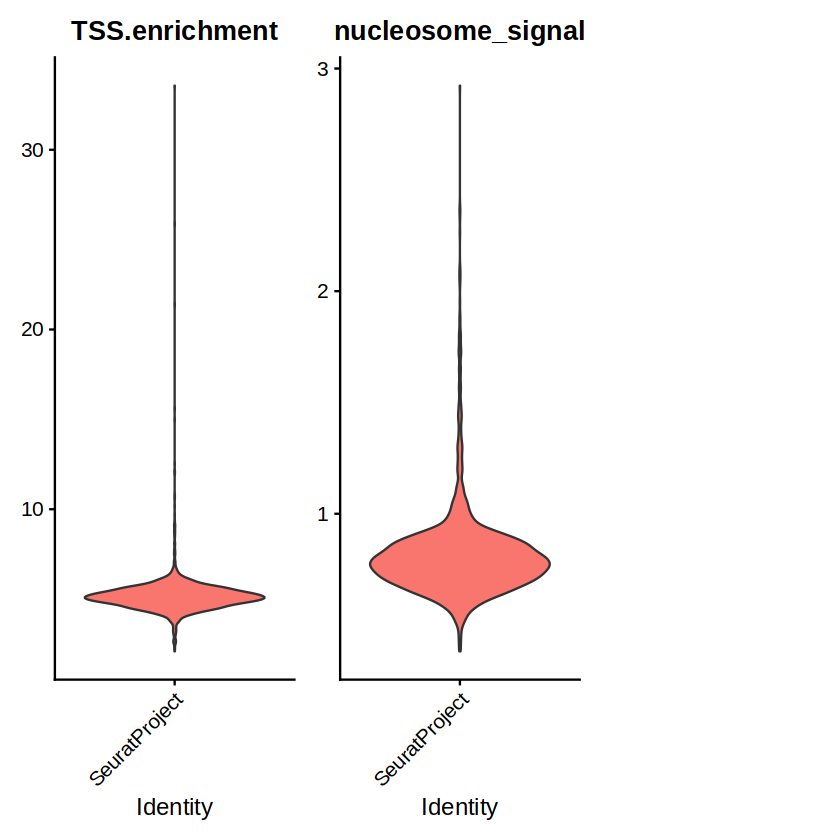

In [25]:
VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)


In [26]:
cell.sel <- intersect(colnames(obj.rna), colnames(obj.atac))

In [27]:
obj.rna <- subset(obj.rna, cells = cell.sel)
obj.atac <- subset(obj.atac, cells = cell.sel)

In [28]:
obj.atac

An object of class Seurat 
151450 features across 2617 samples within 1 assay 
Active assay: ATAC (151450 features, 0 variable features)
 2 layers present: counts, data

In [29]:
#接下来，我们使用标准 Seurat 和 Signac 分析流程处理 scRNA-seq 和 scATAC-seq 数据：
# normalization followed by dimensionality reduction
obj.rna <- obj.rna %>%
  NormalizeData(verbose=FALSE) %>%
  FindVariableFeatures(nfeatures=3000, verbose=F) %>%
  ScaleData() %>%
  RunPCA(verbose = FALSE) %>%
  RunUMAP(dims = 1:30, verbose = FALSE)

obj.atac <- obj.atac %>%
  RunTFIDF() %>%
  FindTopFeatures() %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30, verbose = FALSE)

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



In [30]:
obj.rna

An object of class Seurat 
36601 features across 2617 samples within 1 assay 
Active assay: RNA (36601 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

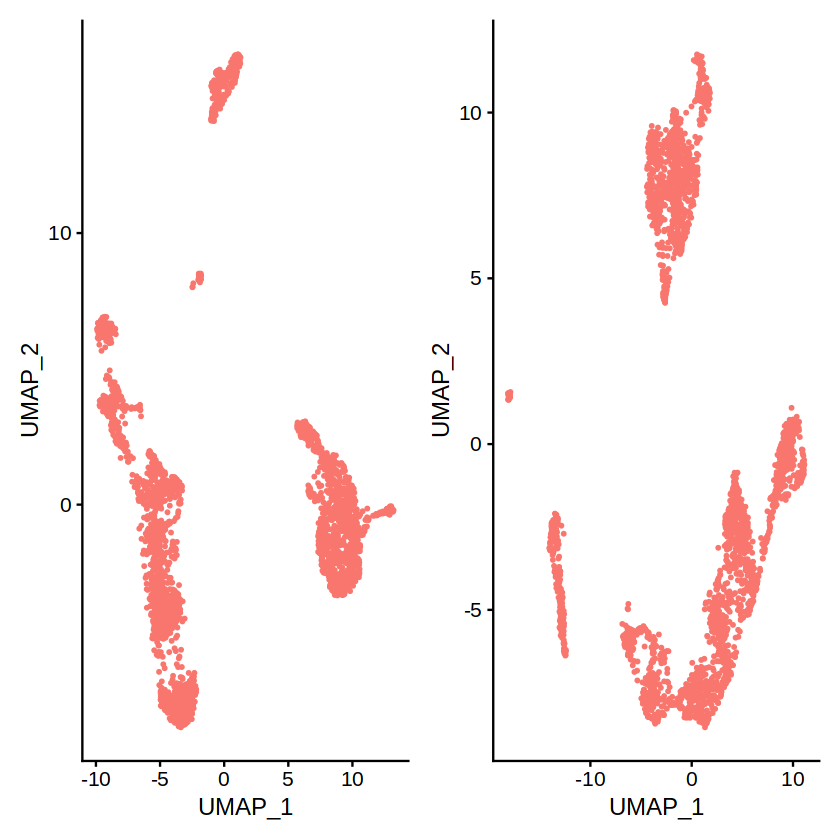

In [31]:
p1 <- DimPlot(obj.rna) + NoLegend()
p2 <- DimPlot(obj.atac) + NoLegend()

p1 + p2

#ggsave(filename='plot3.png',plot=p1+p2,width=16,height=8,dpi=600)

In [32]:
setwd("./models/R-scMEGA")

# 细胞类型注释

In [33]:

reference <- readRDS("seurat.rds")
reference <- UpdateSeuratObject(object = reference)


Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [34]:
#手动更新
reference[["RNA"]] <- CreateAssayObject(counts = reference[["RNA"]]@counts)
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [35]:
# we only keep cells with annotated cell type
reference <- subset(reference, subset = celltype != "NA")

Warning message:
"Removing 1877 cells missing data for vars requested"


In [36]:

    reference <- reference %>%
    NormalizeData(verbose=FALSE) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData() %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

# run sctransform


Centering and scaling data matrix

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



In [37]:
mem_used()

5.7 GB

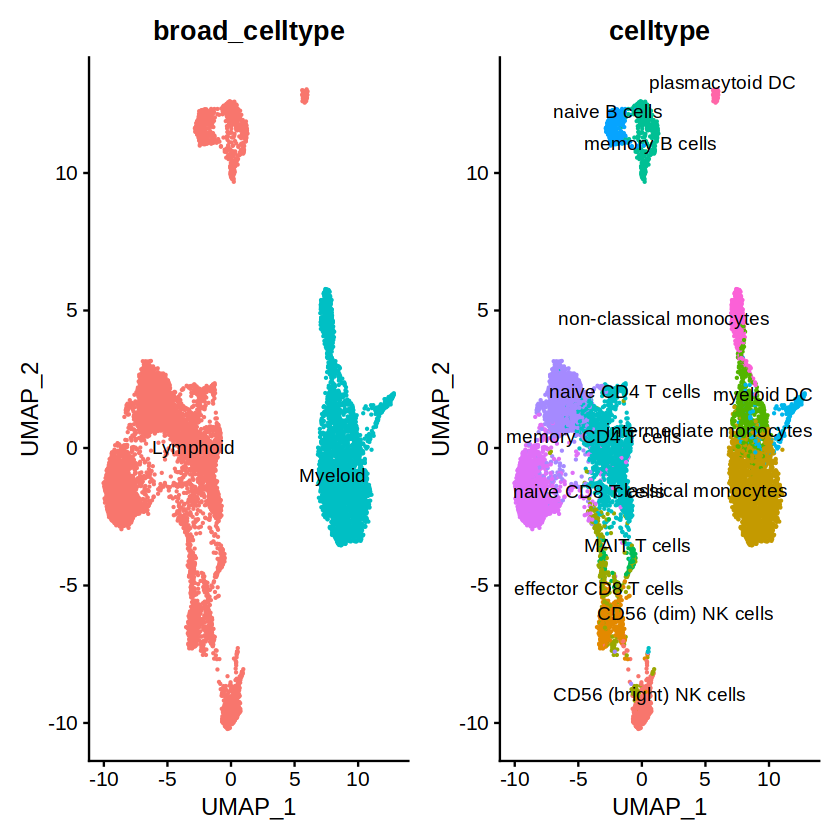

In [38]:
p1 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "broad_celltype") + NoLegend()

p2 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "celltype") + NoLegend()

p1 + p2

#ggsave(filename='umap.png',plot=p1+p2,width=16,height=8,dpi=600)

In [39]:
    transfer_anchors <- FindTransferAnchors(
  reference = reference,
  query = obj.rna,
  reference.reduction = "pca",
  dims = 1:30
)


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 8922 anchors

Filtering anchors

	Retained 6868 anchors



In [40]:
predictions <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference$celltype,
  weight.reduction = obj.rna[['pca']],
  dims = 1:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [41]:
predictions 

,predicted.id,prediction.score.naive.CD4.T.cells,prediction.score.memory.CD4.T.cells,prediction.score.non.classical.monocytes,prediction.score.naive.CD8.T.cells,prediction.score.CD56..bright..NK.cells,prediction.score.classical.monocytes,prediction.score.effector.CD8.T.cells,prediction.score.myeloid.DC,prediction.score.intermediate.monocytes,prediction.score.memory.B.cells,prediction.score.MAIT.T.cells,prediction.score.CD56..dim..NK.cells,prediction.score.naive.B.cells,prediction.score.plasmacytoid.DC,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAAATATCC-1,CD56 (bright) NK cells,0.00000000,0.000000000,0.0000000,0.000000000,1.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACAGCCAGGAACTG-1,intermediate monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.229414867,0.77058513,0.00000000,0.00000000,0.00000000,0.0000000,0,0.7705851
AAACAGCCAGGCTTCG-1,classical monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCAACACCTGCTC-1,naive B cells,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,1.0000000,0,1.0000000
AAACCAACAGATTCAT-1,CD56 (dim) NK cells,0.00000000,0.000000000,0.0000000,0.000000000,0.1583158,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.84168424,0.0000000,0,0.8416842
AAACCAACAGTTGCGT-1,naive CD4 T cells,0.99406447,0.000000000,0.0000000,0.005935532,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,0.9940645
AAACCAACATAACGGG-1,memory CD4 T cells,0.00000000,1.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCAACATAGACCC-1,classical monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCGCGTGAGGTAG-1,memory B cells,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.70081965,0.00000000,0.00000000,0.2991803,0,0.7008197


In [42]:
obj.rna <- AddMetaData(
  object = obj.rna,
  metadata = predictions
)

obj.atac <- AddMetaData(
  object = obj.atac,
  metadata = predictions
)

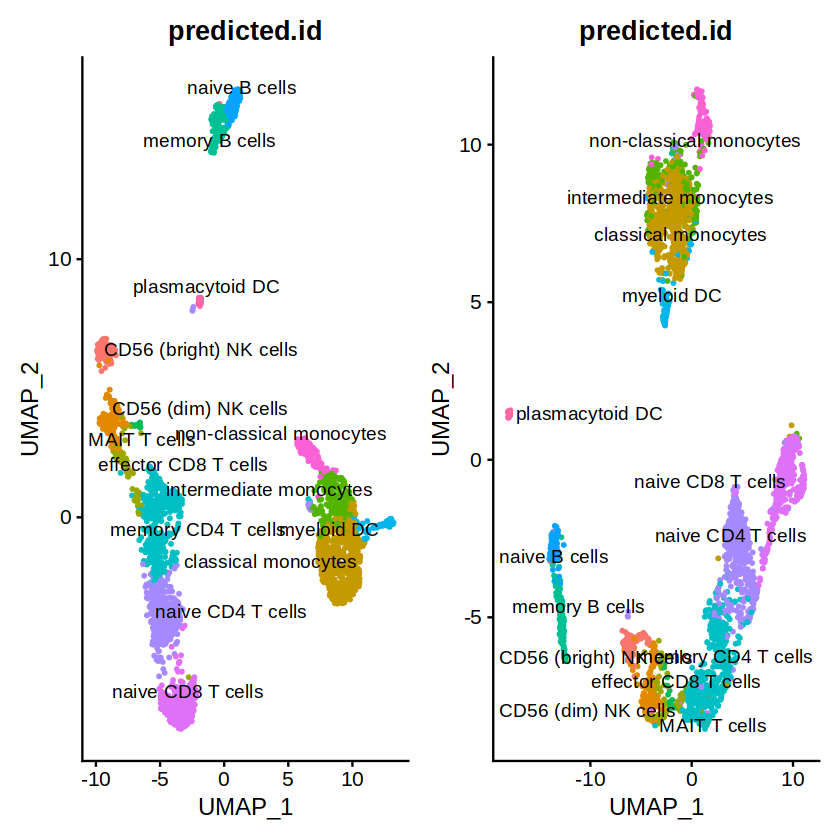

In [43]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p1 + p2
#ggsave(filename='plot5.png',plot=p1+p2,width=16,height=8,dpi=600)

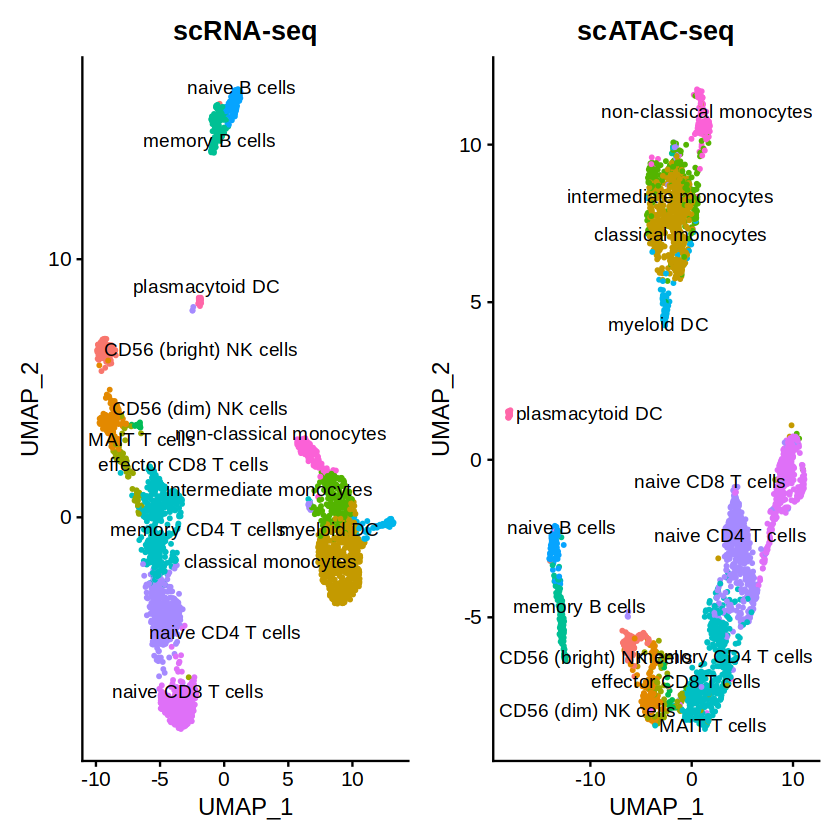

In [44]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend() + ggtitle('scRNA-seq')

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend() +  ggtitle('scATAC-seq')
p1+p2
#ggsave(filename='plot5.png',plot=p1+p2,width=16,height=8,dpi=600)

# 使用 MOJITOO 整合多模态单细胞数据

In [45]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [46]:
meta.data <- obj.rna@meta.data %>%
    as.data.frame()



In [47]:
meta.data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,predicted.id,prediction.score.naive.CD4.T.cells,prediction.score.memory.CD4.T.cells,prediction.score.non.classical.monocytes,prediction.score.naive.CD8.T.cells,prediction.score.CD56..bright..NK.cells,prediction.score.classical.monocytes,prediction.score.effector.CD8.T.cells,prediction.score.myeloid.DC,prediction.score.intermediate.monocytes,prediction.score.memory.B.cells,prediction.score.MAIT.T.cells,prediction.score.CD56..dim..NK.cells,prediction.score.naive.B.cells,prediction.score.plasmacytoid.DC,prediction.score.max
,<fct>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAAATATCC-1,SeuratProject,4747,2272,7.773331,CD56 (bright) NK cells,0.00000000,0.000000000,0.0000000,0.000000000,1.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACAGCCAGGAACTG-1,SeuratProject,7761,3254,8.929262,intermediate monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.229414867,0.77058513,0.00000000,0.00000000,0.00000000,0.0000000,0,0.7705851
AAACAGCCAGGCTTCG-1,SeuratProject,3666,1798,11.156574,classical monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCAACACCTGCTC-1,SeuratProject,2162,1145,12.534690,naive B cells,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,1.0000000,0,1.0000000
AAACCAACAGATTCAT-1,SeuratProject,2910,1495,10.068729,CD56 (dim) NK cells,0.00000000,0.000000000,0.0000000,0.000000000,0.1583158,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.84168424,0.0000000,0,0.8416842
AAACCAACAGTTGCGT-1,SeuratProject,2616,1342,8.142202,naive CD4 T cells,0.99406447,0.000000000,0.0000000,0.005935532,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,0.9940645
AAACCAACATAACGGG-1,SeuratProject,6662,2589,4.623236,memory CD4 T cells,0.00000000,1.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCAACATAGACCC-1,SeuratProject,5632,2385,12.357955,classical monocytes,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0,1.0000000
AAACCGCGTGAGGTAG-1,SeuratProject,7583,3009,10.787287,memory B cells,0.00000000,0.000000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000,0.000000000,0.00000000,0.70081965,0.00000000,0.00000000,0.2991803,0,0.7008197


In [48]:
# create a Seurat object containing the RNA adata
pbmc <- CreateSeuratObject(
  counts = obj.rna@assays$RNA@counts,
  assay = "RNA",
    meta.data = meta.data
)



In [49]:
colnames(pbmc)

[1] "AAACAGCCAAATATCC-1" "AAACAGCCAGGAACTG-1" "AAACAGCCAGGCTTCG-1"
   [4] "AAACCAACACCTGCTC-1" "AAACCAACAGATTCAT-1" "AAACCAACAGTTGCGT-1"
   [7] "AAACCAACATAACGGG-1" "AAACCAACATAGACCC-1" "AAACCGCGTGAGGTAG-1"
  [10] "AAACGCGCATACCCGG-1" "AAACGGATCCTAGTAA-1" "AAACGTACAAATACCT-1"
  [13] "AAAGCACCACCCACCT-1" "AAAGCTTGTGTGTGGT-1" "AAAGGACGTATTGTGG-1"
  [16] "AAAGGACGTCATCCTG-1" "AAAGGACGTTAAGCCA-1" "AAAGGACGTTCACCAT-1"
  [19] "AAAGGAGCACAAACTT-1" "AAAGGAGCATAGCTGC-1" "AAAGGCTCACCGTTCC-1"
  [22] "AAAGGCTCACTTCACT-1" "AAAGGTTAGCAAGGGT-1" "AAAGGTTAGGGTGGAT-1"
  [25] "AAATCCGGTTAGCGTA-1" "AAATGCCTCCAGGAAA-1" "AAATGCCTCGCTAAAC-1"
  [28] "AACAAAGGTAATGGAA-1" "AACAAGCCAGGTTCAC-1" "AACAGATAGAGGCTAA-1"
  [31] "AACAGATAGGGTCCAC-1" "AACAGCAAGGAAGCTA-1" "AACAGGATCACTAGGT-1"
  [34] "AACAGGATCATCACTT-1" "AACAGGATCTACCTGC-1" "AACATAGCATAAAGCA-1"
  [37] "AACATCATCCGTTATT-1" "AACATCATCGAGGAAC-1" "AACATCATCGGCTATG-1"
  [40] "AACCCGCAGTAACAGG-1" "AACCCGCAGTCACTAA-1" "AACCGGCTCCGTAAAC-1"
  [43] "AACCGGCTCGATCAGT-1" "AACCGGCTCGTTAGCG-1" "AACCTCCTCCCTCACG-1"
  [46] "AACCTTAAGGTCTTGG-1" "AACCTTGCAATAATCC-1" "AACCTTGCAGCCTGCA-1"
  [49] "AACGACAAGGACCGCT-1" "AACGCCCAGTTTGAGC-1" "AACGGTAAGCTGCACA-1"
  [52] "AACTAGTGTAACCAGC-1" "AACTAGTGTCGTAATG-1" "AACTAGTGTGTTGCTT-1"
  [55] "AACTCACAGCACTAAC-1" "AACTCACAGCTAATTG-1" "AACTCACAGGAAGCAC-1"
  [58] "AACTCACAGGGCTAAA-1" "AACTGTTCAAGACTCC-1" "AACTGTTCAGCGCTTG-1"
  [61] "AACTTAGTCCATAATG-1" "AACTTAGTCGCGCTAA-1" "AAGAACAGTATTCGTC-1"
  [64] "AAGAATCAGGCTACAT-1" "AAGACATAGTAAGGGC-1" "AAGACCAAGAGAGGAG-1"
  [67] "AAGACCAAGTTGTCTT-1" "AAGCAAGTCATTGCAA-1" "AAGCAAGTCGTTTCGC-1"
  [70] "AAGCCTCCACAATGCC-1" "AAGCCTCCACACTAAT-1" "AAGCCTCCAGACAAAC-1"
  [73] "AAGCCTTAGGAATAAC-1" "AAGCCTTAGGCTAAGA-1" "AAGCGAATCATGCCTC-1"
  [76] "AAGCGAGGTATCTGGA-1" "AAGCGAGGTCGACTCC-1" "AAGCGAGGTTACCGGG-1"
  [79] "AAGCGAGGTTGCACGG-1" "AAGCGCTGTATTGCAG-1" "AAGCGTTTCATTGTCT-1"
  [82] "AAGCGTTTCCTGATTT-1" "AAGCGTTTCGCACACA-1" "AAGCTAGAGATGGACA-1"
  [85] "AAGCTATGTTACTTGC-1" "AAGCTATGTTTAACCC-1" "AAGCTCCCAGCAATAA-1"
  [88] "AAGCTTGGTCGCAATA-1" "AAGGATCCAGTCTAGC-1" "AAGGATGTCTCATCAT-1"
  [91] "AAGGATTAGTAGCGCC-1" "AAGGCCCTCTTGATGA-1" "AAGGTATAGTAGCGGG-1"
  [94] "AAGGTCAAGAATGACG-1" "AAGGTCAAGCACAGAA-1" "AAGGTCAAGGTCCGTA-1"
  [97] "AAGTAGCCACGGTTTA-1" "AAGTAGCCAGTTTGGC-1" "AAGTGAAGTATGTGGC-1"
 [100] "AAGTGTTGTGAGACTC-1" "AAGTGTTGTGCTCCGT-1" "AAGTGTTGTTGAGGTC-1"
 [103] "AAGTGTTGTTTCGCCA-1" "AAGTGTTGTTTGCAGA-1" "AAGTTACGTAGCTAGC-1"
 [106] "AAGTTAGCACCTCAGG-1" "AAGTTAGCACTAAGAA-1" "AAGTTTGTCAAGGACA-1"
 [109] "AAGTTTGTCCAATTAG-1" "AAGTTTGTCTAAGTGC-1" "AATACCGGTTCCATTA-1"
 [112] "AATAGAGGTATTCGTC-1" "AATAGAGGTGAGGTAG-1" "AATCAGGAGCGAAGTA-1"
 [115] "AATCATCCAATCCTGA-1" "AATCATGTCATTACTC-1" "AATCCATCACCTCAGG-1"
 [118] "AATCCCTGTGCAATAT-1" "AATCCCTGTTAGCCAA-1" "AATCCTAAGATGGAGC-1"
 [121] "AATCCTAAGCGGGCAA-1" "AATCCTAAGTTGGATC-1" "AATCGCCCACAGCCAT-1"
 [124] "AATCTCAAGCACTAGT-1" "AATGAAGGTAGGTTAT-1" "AATGCAACAAGGTATA-1"
 [127] "AATGCAACACACTAAT-1" "AATGCAACACCACAAC-1" "AATGCATGTGTTTCAC-1"
 [130] "AATGCGCGTACCGGAT-1" "AATGGCGCAAGCCACT-1" "AATGGCGCAGTCTATG-1"
 [133] "AATGGCGCATCACTTC-1" "AATGGCGCATTAGCGC-1" "AATGTCCAGGTAACGA-1"
 [136] "AATTACCCACCTGCCT-1" "AATTAGGCATTTAAGC-1" "AATTCGTCACTTAGGC-1"
 [139] "AATTCGTCAGCAGGTA-1" "AATTCGTCAGGCTAAG-1" "AATTGCCAGGGCTTTG-1"
 [142] "AATTGCCAGTACTGGT-1" "AATTGGACATCGCTCC-1" "AATTGGGAGCCAGGTC-1"
 [145] "AATTGTGTCCATCAGG-1" "AATTTGGTCCCGAAGC-1" "ACAAAGGTCCCTGTTA-1"
 [148] "ACAACACTCCTGAATA-1" "ACAACAGAGGTCCTAG-1" "ACACCTTGTACGTTTC-1"
 [151] "ACACCTTGTCATCAAG-1" "ACACCTTGTCCTAAGA-1" "ACACGGACAGGCGATA-1"
 [154] "ACACGGACATGGTTAT-1" "ACACTAATCGCCTGTT-1" "ACACTAATCGTTAGCG-1"
 [157] "ACACTTAAGCGCTCAA-1" "ACACTTGCACTATGGC-1" "ACAGGAATCAAGCTAC-1"
 [160] "ACAGGAATCAATGACC-1" "ACAGGAATCAATGTCA-1" "ACAGGAATCCAGGTCA-1"
 [163] "ACAGGATCAAAGGCCA-1" "ACAGGATCAAGCCAGA-1" "ACAGGATCACCTGCCT-1"
 [166] "ACAGGCTGTCAATGTG-1" "ACATAGCTCATGACCG-1" "ACATAGCTCTAGCGTG-1"
 [169] "ACATCAATCACAGCCA-1" "ACATCAATCTCAATTC-1" "ACATCATCACTATGGC-1"
 [172] "ACATT

In [50]:
colnames(obj.atac)

[1] "AAACAGCCAAATATCC-1" "AAACAGCCAGGAACTG-1" "AAACAGCCAGGCTTCG-1"
   [4] "AAACCAACACCTGCTC-1" "AAACCAACAGATTCAT-1" "AAACCAACAGTTGCGT-1"
   [7] "AAACCAACATAACGGG-1" "AAACCAACATAGACCC-1" "AAACCGCGTGAGGTAG-1"
  [10] "AAACGCGCATACCCGG-1" "AAACGGATCCTAGTAA-1" "AAACGTACAAATACCT-1"
  [13] "AAAGCACCACCCACCT-1" "AAAGCTTGTGTGTGGT-1" "AAAGGACGTATTGTGG-1"
  [16] "AAAGGACGTCATCCTG-1" "AAAGGACGTTAAGCCA-1" "AAAGGACGTTCACCAT-1"
  [19] "AAAGGAGCACAAACTT-1" "AAAGGAGCATAGCTGC-1" "AAAGGCTCACCGTTCC-1"
  [22] "AAAGGCTCACTTCACT-1" "AAAGGTTAGCAAGGGT-1" "AAAGGTTAGGGTGGAT-1"
  [25] "AAATCCGGTTAGCGTA-1" "AAATGCCTCCAGGAAA-1" "AAATGCCTCGCTAAAC-1"
  [28] "AACAAAGGTAATGGAA-1" "AACAAGCCAGGTTCAC-1" "AACAGATAGAGGCTAA-1"
  [31] "AACAGATAGGGTCCAC-1" "AACAGCAAGGAAGCTA-1" "AACAGGATCACTAGGT-1"
  [34] "AACAGGATCATCACTT-1" "AACAGGATCTACCTGC-1" "AACATAGCATAAAGCA-1"
  [37] "AACATCATCCGTTATT-1" "AACATCATCGAGGAAC-1" "AACATCATCGGCTATG-1"
  [40] "AACCCGCAGTAACAGG-1" "AACCCGCAGTCACTAA-1" "AACCGGCTCCGTAAAC-1"
  [43] "AACCGGCTCGATCAGT-1" "AACCGGCTCGTTAGCG-1" "AACCTCCTCCCTCACG-1"
  [46] "AACCTTAAGGTCTTGG-1" "AACCTTGCAATAATCC-1" "AACCTTGCAGCCTGCA-1"
  [49] "AACGACAAGGACCGCT-1" "AACGCCCAGTTTGAGC-1" "AACGGTAAGCTGCACA-1"
  [52] "AACTAGTGTAACCAGC-1" "AACTAGTGTCGTAATG-1" "AACTAGTGTGTTGCTT-1"
  [55] "AACTCACAGCACTAAC-1" "AACTCACAGCTAATTG-1" "AACTCACAGGAAGCAC-1"
  [58] "AACTCACAGGGCTAAA-1" "AACTGTTCAAGACTCC-1" "AACTGTTCAGCGCTTG-1"
  [61] "AACTTAGTCCATAATG-1" "AACTTAGTCGCGCTAA-1" "AAGAACAGTATTCGTC-1"
  [64] "AAGAATCAGGCTACAT-1" "AAGACATAGTAAGGGC-1" "AAGACCAAGAGAGGAG-1"
  [67] "AAGACCAAGTTGTCTT-1" "AAGCAAGTCATTGCAA-1" "AAGCAAGTCGTTTCGC-1"
  [70] "AAGCCTCCACAATGCC-1" "AAGCCTCCACACTAAT-1" "AAGCCTCCAGACAAAC-1"
  [73] "AAGCCTTAGGAATAAC-1" "AAGCCTTAGGCTAAGA-1" "AAGCGAATCATGCCTC-1"
  [76] "AAGCGAGGTATCTGGA-1" "AAGCGAGGTCGACTCC-1" "AAGCGAGGTTACCGGG-1"
  [79] "AAGCGAGGTTGCACGG-1" "AAGCGCTGTATTGCAG-1" "AAGCGTTTCATTGTCT-1"
  [82] "AAGCGTTTCCTGATTT-1" "AAGCGTTTCGCACACA-1" "AAGCTAGAGATGGACA-1"
  [85] "AAGCTATGTTACTTGC-1" "AAGCTATGTTTAACCC-1" "AAGCTCCCAGCAATAA-1"
  [88] "AAGCTTGGTCGCAATA-1" "AAGGATCCAGTCTAGC-1" "AAGGATGTCTCATCAT-1"
  [91] "AAGGATTAGTAGCGCC-1" "AAGGCCCTCTTGATGA-1" "AAGGTATAGTAGCGGG-1"
  [94] "AAGGTCAAGAATGACG-1" "AAGGTCAAGCACAGAA-1" "AAGGTCAAGGTCCGTA-1"
  [97] "AAGTAGCCACGGTTTA-1" "AAGTAGCCAGTTTGGC-1" "AAGTGAAGTATGTGGC-1"
 [100] "AAGTGTTGTGAGACTC-1" "AAGTGTTGTGCTCCGT-1" "AAGTGTTGTTGAGGTC-1"
 [103] "AAGTGTTGTTTCGCCA-1" "AAGTGTTGTTTGCAGA-1" "AAGTTACGTAGCTAGC-1"
 [106] "AAGTTAGCACCTCAGG-1" "AAGTTAGCACTAAGAA-1" "AAGTTTGTCAAGGACA-1"
 [109] "AAGTTTGTCCAATTAG-1" "AAGTTTGTCTAAGTGC-1" "AATACCGGTTCCATTA-1"
 [112] "AATAGAGGTATTCGTC-1" "AATAGAGGTGAGGTAG-1" "AATCAGGAGCGAAGTA-1"
 [115] "AATCATCCAATCCTGA-1" "AATCATGTCATTACTC-1" "AATCCATCACCTCAGG-1"
 [118] "AATCCCTGTGCAATAT-1" "AATCCCTGTTAGCCAA-1" "AATCCTAAGATGGAGC-1"
 [121] "AATCCTAAGCGGGCAA-1" "AATCCTAAGTTGGATC-1" "AATCGCCCACAGCCAT-1"
 [124] "AATCTCAAGCACTAGT-1" "AATGAAGGTAGGTTAT-1" "AATGCAACAAGGTATA-1"
 [127] "AATGCAACACACTAAT-1" "AATGCAACACCACAAC-1" "AATGCATGTGTTTCAC-1"
 [130] "AATGCGCGTACCGGAT-1" "AATGGCGCAAGCCACT-1" "AATGGCGCAGTCTATG-1"
 [133] "AATGGCGCATCACTTC-1" "AATGGCGCATTAGCGC-1" "AATGTCCAGGTAACGA-1"
 [136] "AATTACCCACCTGCCT-1" "AATTAGGCATTTAAGC-1" "AATTCGTCACTTAGGC-1"
 [139] "AATTCGTCAGCAGGTA-1" "AATTCGTCAGGCTAAG-1" "AATTGCCAGGGCTTTG-1"
 [142] "AATTGCCAGTACTGGT-1" "AATTGGACATCGCTCC-1" "AATTGGGAGCCAGGTC-1"
 [145] "AATTGTGTCCATCAGG-1" "AATTTGGTCCCGAAGC-1" "ACAAAGGTCCCTGTTA-1"
 [148] "ACAACACTCCTGAATA-1" "ACAACAGAGGTCCTAG-1" "ACACCTTGTACGTTTC-1"
 [151] "ACACCTTGTCATCAAG-1" "ACACCTTGTCCTAAGA-1" "ACACGGACAGGCGATA-1"
 [154] "ACACGGACATGGTTAT-1" "ACACTAATCGCCTGTT-1" "ACACTAATCGTTAGCG-1"
 [157] "ACACTTAAGCGCTCAA-1" "ACACTTGCACTATGGC-1" "ACAGGAATCAAGCTAC-1"
 [160] "ACAGGAATCAATGACC-1" "ACAGGAATCAATGTCA-1" "ACAGGAATCCAGGTCA-1"
 [163] "ACAGGATCAAAGGCCA-1" "ACAGGATCAAGCCAGA-1" "ACAGGATCACCTGCCT-1"
 [166] "ACAGGCTGTCAATGTG-1" "ACATAGCTCATGACCG-1" "ACATAGCTCTAGCGTG-1"
 [169] "ACATCAATCACAGCCA-1" "ACATCAATCTCAATTC-1" "ACATCATCACTATGGC-1"
 [172] "ACATT

In [51]:
# create ATAC assay and add it to the object
pbmc[["ATAC"]] <- CreateChromatinAssay(
  counts = obj.atac@assays$ATAC@counts,
  sep = c(":", "-"),
    min.cells = 1,
    genome = 'hg38',
    fragments = './3KPBMC/atac_fragments.tsv.gz'
)

Computing hash



In [52]:
## RNA pre-processing and PCA dimension reduction
DefaultAssay(pbmc) <- "RNA"

pbmc <- pbmc %>%
    NormalizeData(verbose=F) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData(verbose=F) %>%
    RunPCA(npcs=50, reduction.name="RNA_PCA", verbose=F)

In [53]:
## ATAC pre-processing and LSI dimension reduction
DefaultAssay(pbmc) <- "ATAC"

pbmc <- pbmc %>%
    RunTFIDF(verbose=F) %>%
    FindTopFeatures(min.cutoff = 'q0', verbose=F) %>%
    RunSVD(verbose=F)

In [54]:
str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ RNA :Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964 11306 13895 16280 19289 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 36601 2617
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:36601] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. .. .. .. .. .. ..$ : chr [1:2617] "AAACAGCCAAATATCC-1" "AAACAGCCAGGAACTG-1" "AAACAGCCAGGCTTCG-1" "AAACCAACACCTGCTC-1" ...
  .. .. .. .. .. ..@ x       : num [1:5034927] 1 2 1 1 1 1 1 1 1 3 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 8

In [55]:
#MOJITOO

In [56]:

pbmc <- mojitoo(
     object = pbmc,
     reduction.list = list("RNA_PCA", "lsi"),
     dims.list = list(1:50, 2:50), ## exclude 1st dimension of LSI
     reduction.name = 'MOJITOO',
     assay = "RNA"
)

processing RNA_PCA

adding lsi

1 round cc 43

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from MOJITOO to MOJITOO_"


In [57]:
DefaultAssay(pbmc) <- "RNA"
embedd <- Embeddings(pbmc[["MOJITOO"]])
pbmc <- RunUMAP(pbmc, 
                reduction="MOJITOO", 
                reduction.name="MOJITOO_UMAP", 
                dims=1:ncol(embedd), verbose=F)

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'



In [58]:
p<-DimPlot(pbmc, group.by = "predicted.id", 
        shuffle = TRUE, label = TRUE, reduction = "MOJITOO_UMAP") + NoLegend()


#ggsave(filename='plot6.png',plot=p,width=16,height=16,dpi=600)

In [59]:
#轨迹分析

In [60]:
##接下来，我们推断从幼稚 CD4 T 细胞到记忆 CD4 T 细胞的轨迹，以表征 CD4+ T 细胞活化

In [61]:
pbmc <- AddTrajectory(object = pbmc, 
                      trajectory = c("naive CD4 T cells", 
                                     "memory CD4 T cells"),
                      group.by = "predicted.id", 
                          reduction = "MOJITOO_UMAP",
                          dims = 1:2, 
                          use.all = FALSE)



In [62]:
# we only plot the cells that are in this trajectory
pbmc.t.cells <- pbmc[, !is.na(pbmc$Trajectory)]

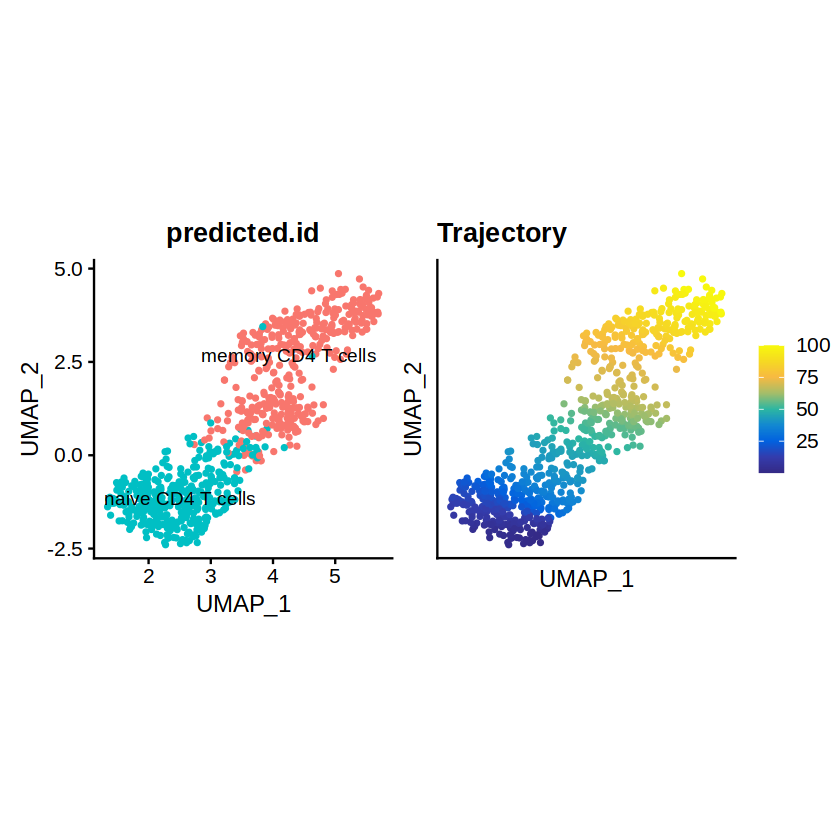

In [63]:
p1 <- DimPlot(object = pbmc.t.cells, 
              group.by = "predicted.id", 
              reduction = "MOJITOO_UMAP",
             label = TRUE) + NoLegend()

p2 <- TrajectoryPlot(object = pbmc.t.cells, 
                    reduction = "MOJITOO_UMAP",
                    continuousSet = "blueYellow",
                    size = 1,
                   addArrow = FALSE)
p1 + p2

#ggsave(filename='plot7.png',plot=p1+p2,width=16,height=8,dpi=600)

In [64]:
pbmc.t.cells1<- pbmc.t.cells

In [68]:
pbmc.t.cells<- pbmc.t.cells1

In [65]:
library(peakRAM)

Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Find 559 shared features!

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Linking cis-regulatory elements to genes...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Filtering network by peak-to-gene links...

Filtering network by TF binding site prediction...

Warning message:
"Using alpha for a discrete

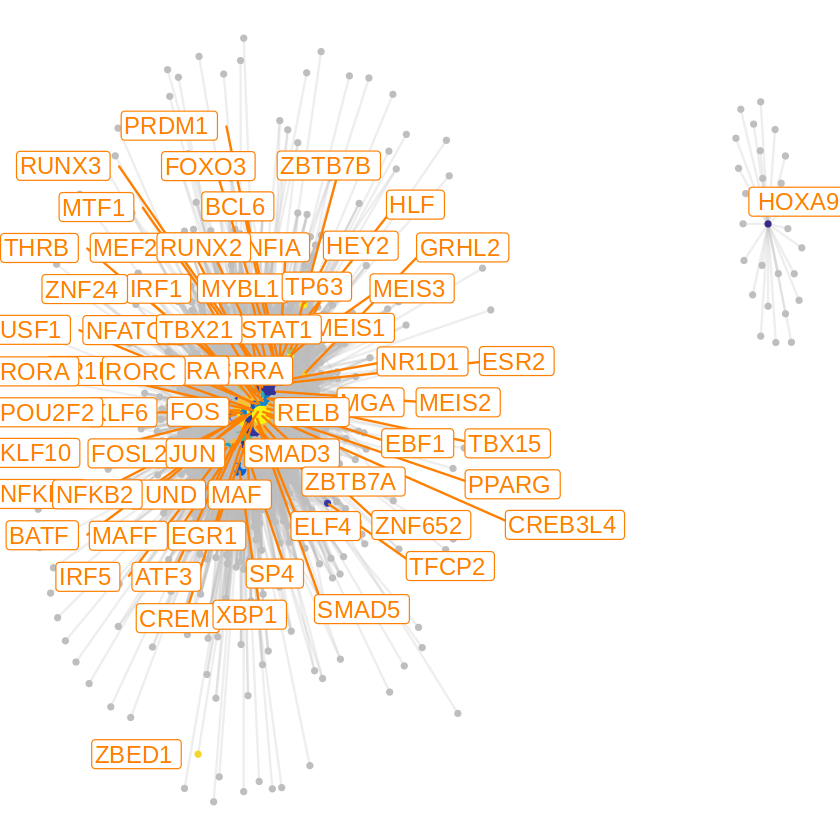

In [69]:
result <- peakRAM({
  # 多行代码示例
 pbmc.t.cells <- AddMotifs(object = pbmc.t.cells,genome = BSgenome.Hsapiens.UCSC.hg38,pfm = pfm,assay = "ATAC")
    
   # run chromVAR
 pbmc.t.cells <- RunChromVAR(object = pbmc.t.cells,genome = BSgenome.Hsapiens.UCSC.hg38,assay = "ATAC")
 sel.tfs <- SelectTFs(object = pbmc.t.cells, 
                return.heatmap = TRUE,
                cor.cutoff = 0.4)
 df.cor <- sel.tfs$tfs
# ht <- sel.tfs$heatmap
 
 sel.genes <- SelectGenes(object = pbmc.t.cells,
                  labelTop1 = 0,
                  labelTop2 = 0)

  df.p2g <- sel.genes$p2g
#  ht <- sel.genes$heatmap
  tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")
  #ht <- GRNHeatmap(tf.gene.cor, tf.timepoint = df.cor$time_point)
 motif.matching <- pbmc.t.cells@assays$ATAC@motifs@data
 colnames(motif.matching) <- pbmc.t.cells@assays$ATAC@motifs@motif.names
 motif.matching <- motif.matching[unique(df.p2g$peak), unique(tf.gene.cor$tf)]

 df.grn <- GetGRN(motif.matching = motif.matching, 
                 df.cor = tf.gene.cor, 
                 df.p2g = df.p2g)
    
  # define colors for nodes representing TFs (i.e., regulators)
 df.cor <- df.cor[order(df.cor$time_point), ]
 tfs.timepoint <- df.cor$time_point
 names(tfs.timepoint) <- df.cor$tfs

# plot the graph, here we can highlight some genes
 df.grn2 <- df.grn %>%
    subset(correlation > 0.5) %>%
    select(c(tf, gene, correlation)) %>%
    rename(weights = correlation)

 p <- GRNPlot(df.grn2, 
             tfs.timepoint = tfs.timepoint,
             show.tf.labels = TRUE,
             seed = 42, 
             plot.importance = FALSE,
            min.importance = 2,
            remove.isolated = FALSE)

 print(p)  
    
})

print(result)

# TF 和基因选择

#选择TF

In [62]:
#To identify potential regulator (i.e., TFs), we first estimate an acitivty score for each TF in each cell. This is done by first performing motif matching and then computing deviation scores using chromVAR

In [66]:
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)



In [ ]:
mem_used()

In [ ]:

  # add motif information
pbmc.t.cells <- AddMotifs(
  object = pbmc.t.cells,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  pfm = pfm,
    assay = "ATAC"
)


In [ ]:
# run chromVAR
pbmc.t.cells <- RunChromVAR(
  object = pbmc.t.cells,
  genome = BSgenome.Hsapiens.UCSC.hg38,
    assay = "ATAC"
)


In [ ]:
pbmc.t.cells 

In [ ]:
sel.tfs <- SelectTFs(object = pbmc.t.cells, 
                 return.heatmap = TRUE,
                cor.cutoff = 0.4)


In [85]:
#saveRDS(pbmc.t.cells, file = "./models/R-scMEGA/pbmcafterchromvar.rds")

In [86]:
#pbmc.t.cells<-readRDS("./models/R-scMEGA/pbmcafterchromvar.rds")


In [69]:
setwd("./models/R-scMEGA")

In [ ]:
df.cor <- sel.tfs$tfs
ht <- sel.tfs$heatmap
draw(ht)
#ggsave(filename='plot8.png',plot=ht,width=16,height=16,dpi=600)

pdf("plot_output1.pdf")
ht
dev.off()

In [90]:
#选择基因

In [ ]:

 sel.genes <- SelectGenes(object = pbmc.t.cells,
                  labelTop1 = 0,
                  labelTop2 = 0)


In [ ]:
df.p2g <- sel.genes$p2g
ht <- sel.genes$heatmap

draw(ht)
#ggsave(filename='plot9.png',plot=ht,width=16,height=16,dpi=600)

pdf("plot_output2.pdf")
ht
dev.off()

# 基因调控网络推断与可视化

In [95]:
###在这里，我们将尝试根据从 snATAC-seq 估计的 TF 结合活性与沿轨迹由 snRNA-seq 测量的基因表达之间的相关性来预测基因调控网络

In [ ]:
tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")



In [ ]:
tf.gene.cor 

tf.gene.cor <- GetTFGeneCorrelation(object = pbmc.t.cells, 
                                    tf.use = df.cor$tfs, 
                                    gene.use = unique(df.p2g$gene),
                                    tf.assay = "chromvar", 
                                    gene.assay = "RNA",
                                    trajectory.name = "Trajectory")

In [97]:
###然后，我们可以通过热图可视化该相关矩阵。此外，我们可以对基因和 TF 进行聚类，以识别预定义子群体的不同调控模块

In [ ]:
ht <- GRNHeatmap(tf.gene.cor, 
                 tf.timepoint = df.cor$time_point)

In [ ]:
ht

In [100]:
#ggsave(filename='plot10.png',plot=ht,dpi=1200)

pdf("plot_output3.pdf")
ht
dev.off()

In [102]:
###为了将基因与 TF 关联起来，我们将使用峰与基因之间的关联以及 TF 结合位点信息。具体来说，如果某个基因受峰调控，并且该峰与 TF 结合，那么我们认为该基因是该 TF 的靶标。

In [ ]:
motif.matching <- pbmc.t.cells@assays$ATAC@motifs@data
colnames(motif.matching) <- pbmc.t.cells@assays$ATAC@motifs@motif.names
motif.matching <-
    motif.matching[unique(df.p2g$peak), unique(tf.gene.cor$tf)]


df.grn <- GetGRN(motif.matching = motif.matching, 
                 df.cor = tf.gene.cor, 
                 df.p2g = df.p2g)

In [ ]:
motif.matching

In [ ]:
mem_used()

In [ ]:
# define colors for nodes representing TFs (i.e., regulators)
df.cor <- df.cor[order(df.cor$time_point), ]
tfs.timepoint <- df.cor$time_point
names(tfs.timepoint) <- df.cor$tfs

# plot the graph, here we can highlight some genes
df.grn2 <- df.grn %>%
    subset(correlation > 0.5) %>%
    select(c(tf, gene, correlation)) %>%
    rename(weights = correlation)

p <- GRNPlot(df.grn2, 
             tfs.timepoint = tfs.timepoint,
             show.tf.labels = TRUE,
             seed = 42, 
             plot.importance = FALSE,
            min.importance = 2,
            remove.isolated = FALSE)

print(p)
#ggsave(filename='plot11.png',plot=p,width=16,height=16,dpi=600)

In [69]:
df.grn2

,tf,gene,weights
,<chr>,<chr>,<dbl>
2,ATF3,ACTN4,0.6338836
4,ATF3,ADAM19,0.7686540
6,ATF3,AGPAT3,0.5137207
10,ATF3,ALOX5AP,0.6453673
13,ATF3,ANXA6,0.5047445
18,ATF3,APOBEC3C,0.6971483
19,ATF3,APOBEC3G,0.7289609
20,ATF3,ARFGAP3,0.6468145
21,ATF3,ARHGAP35,0.5671611


In [71]:
#GRN 可视化

In [72]:
pbmc.t.cells <- AddTargetAssay(object = pbmc.t.cells, df.grn = df.grn2)

p1 <- PseudotimePlot(object = pbmc.t.cells, tf.use = "SOX4")

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



In [73]:
p2 <- PseudotimePlot(object = pbmc.t.cells, tf.use = "TCF4")

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...

Creating Trajectory Group Matrix..

Smoothing...

Creating Trajectory Group Matrix..

Some values are below 0, this could be the Motif activity matrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


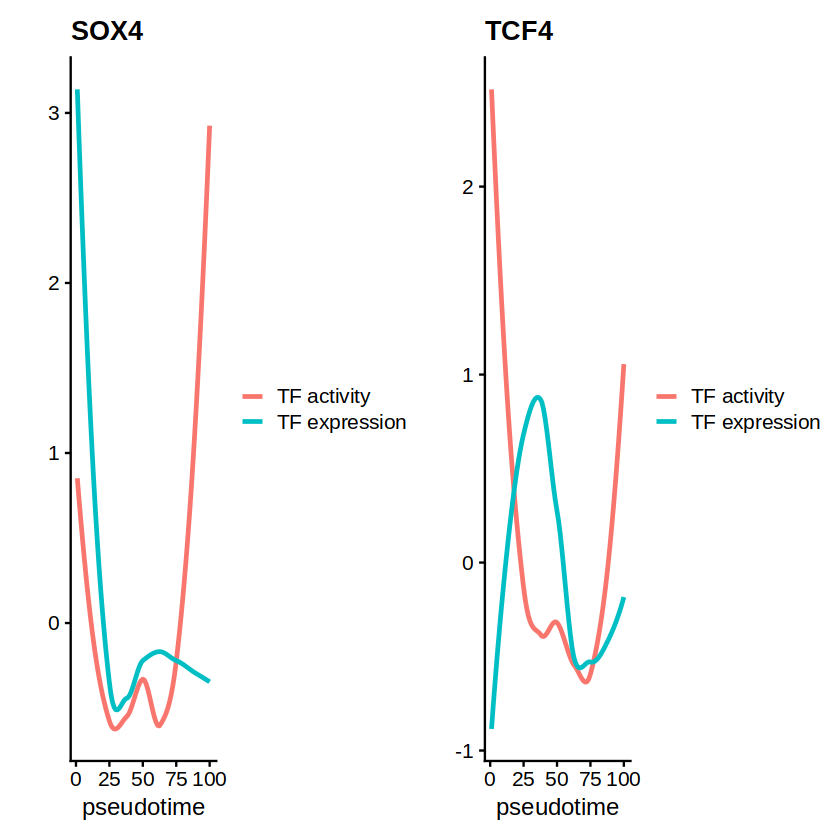

In [74]:
p1 + p2
#ggsave(filename='plot12.png',plot=p1+p2,width=16,height=8,dpi=600)

In [ ]:
###上图中的 x 轴表示轨迹上的伪时间点，y 轴表示 z 分数转换后的 TF 结合活性、TF 表达和 TF 靶标表达。

In [75]:
# Check session information
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.4 (Seafoam Ocelot)

Matrix products: default
BLAS/LAPACK: /mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/.conda/envs/R1/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
 [1] stats4    grid      parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.16                   ComplexHeatmap_2.18.0            
 [3] peakRAM_1.0.2                     hdf5r_1.3.11        

In [76]:
mem_used()

7.9 GB